# Case study: VAT rates across Europe

There's a <code>last_updated</code> ISO 8601 timestamp in the root that tells when the last VAT change (or bug fix) was made, and there is a <code>disclaimer</code>. The <code>rates</code> object contains all the different rates per country, based on its 2 character country code:

 ```
 countries = {
  "AT": "Austria",
  "BE": "Belgium",
  "BG": "Bulgaria",
  "CY": "Cyprus",
  "CZ": "Czech Republic",
  "DE": "Germany",
  "DK": "Denmark",
  "EE": "Estonia",
  "GR": "Greece", 
  "ES": "Spain",
  "FI": "Finland",
  "FR": "France",
  "HR": "Croatia",
  "HU": "Hungary",
  "IE": "Ireland",
  "IT": "Italy",
  "LT": "Lithuania",
  "LU": "Luxembourg",
  "LV": "Latvia",
  "MT": "Malta",
  "NL": "The Netherlands",
  "PL": "Poland",
  "PT": "Portugal",
  "RO": "Romania",
  "SE": "Sweden",
  "SI": "Slovenia",
  "SK": "Slovakia"
}
 ```
The rate object contains the country name, the local name of the tax in the local language, its abbreviation, and a couple of different tax rates that exist in the country. The values are always numeric (with decimals), or a boolean false if the rate is not used in the country.

- **Standard VAT rate (standard_rate)**: Rate that EU countries have to apply to all non-exempt goods and services.
- **Reduced rates of VAT (reduced_rate)**: EU countries have also the option to apply one or two reduced rates.

# Architectural overview

![Architectureal Overview](resources/images/architecture-overview.png)

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import mean
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
spark = SparkSession \
        .builder \
        .appName('Adidas Case Study') \
        .master("local[*]") \
        .config("spark.driver.bindAddress", "127.0.0.1") \
        .getOrCreate()

sc = SparkContext.getOrCreate()

In [3]:
file_path = 'resources/data/rates.json'

In [4]:
sns.set_style(style="whitegrid")

# 1. Load the data

In [5]:
df = pd.read_json(file_path)

In [6]:
df.head()

,last_updated,disclaimer,rates
AT,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Austria', 'vat_name': 'Umsatzsteu..."
BE,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Belgium', 'vat_name': 'Taxe sur l..."
BG,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Bulgaria', 'vat_name': 'Dana Doba..."
CY,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Cyprus', 'vat_name': 'Foros prost..."
CZ,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Czech Republic', 'vat_name': 'Dan..."


In [7]:
df_flattened = pd.concat([df.drop(['last_updated', 'disclaimer', 'rates'], axis=1), \
                          df.rates.apply(pd.Series)], axis=1)
df_flattened.head(5)

,country,vat_name,vat_abbr,standard_rate,reduced_rate,reduced_rate_alt,super_reduced_rate,parking_rate
AT,Austria,Umsatzsteuer,USt,20.0,10,13,False,12
BE,Belgium,Taxe sur la valeur ajoutée,TVA/BTW,21.0,12,6,False,12
BG,Bulgaria,Dana Dobavena Stoynost,DDS,20.0,9,False,False,False
CY,Cyprus,Foros prostithemenis axias,FPA,19.0,9,5,False,False
CZ,Czech Republic,Dani z pridane hotnoty,DPH,21.0,15,10,False,False


Check column types

In [8]:
df_flattened.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, AT to SK
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27 non-null     object 
 1   vat_name            27 non-null     object 
 2   vat_abbr            27 non-null     object 
 3   standard_rate       27 non-null     float64
 4   reduced_rate        27 non-null     object 
 5   reduced_rate_alt    27 non-null     object 
 6   super_reduced_rate  27 non-null     object 
 7   parking_rate        27 non-null     object 
dtypes: float64(1), object(7)
memory usage: 1.9+ KB


Transform numerical columns

In [9]:
num_columns = ['standard_rate', 'reduced_rate', 'reduced_rate_alt', 'super_reduced_rate', 'parking_rate']

In [10]:
(df_flattened[num_columns] == False).sum()

standard_rate          0
reduced_rate           1
reduced_rate_alt       8
super_reduced_rate    23
parking_rate          22
dtype: int64

In [11]:
(df_flattened[num_columns] == 0).sum()

standard_rate          0
reduced_rate           1
reduced_rate_alt       8
super_reduced_rate    23
parking_rate          22
dtype: int64

In [12]:
df_flattened[num_columns] = df_flattened[num_columns].astype(float, errors = 'raise')
df_flattened.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, AT to SK
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27 non-null     object 
 1   vat_name            27 non-null     object 
 2   vat_abbr            27 non-null     object 
 3   standard_rate       27 non-null     float64
 4   reduced_rate        27 non-null     float64
 5   reduced_rate_alt    27 non-null     float64
 6   super_reduced_rate  27 non-null     float64
 7   parking_rate        27 non-null     float64
dtypes: float64(5), object(3)
memory usage: 1.9+ KB


In [13]:
(df_flattened[num_columns] == 0).sum()

standard_rate          0
reduced_rate           1
reduced_rate_alt       8
super_reduced_rate    23
parking_rate          22
dtype: int64

Create Spark DataFrame

In [14]:
spark_df = spark.createDataFrame(df_flattened) 
spark_df.printSchema()
spark_df.show()

root
 |-- country: string (nullable = true)
 |-- vat_name: string (nullable = true)
 |-- vat_abbr: string (nullable = true)
 |-- standard_rate: double (nullable = true)
 |-- reduced_rate: double (nullable = true)
 |-- reduced_rate_alt: double (nullable = true)
 |-- super_reduced_rate: double (nullable = true)
 |-- parking_rate: double (nullable = true)

+--------------+--------------------+--------+-------------+------------+----------------+------------------+------------+
|       country|            vat_name|vat_abbr|standard_rate|reduced_rate|reduced_rate_alt|super_reduced_rate|parking_rate|
+--------------+--------------------+--------+-------------+------------+----------------+------------------+------------+
|       Austria|        Umsatzsteuer|     USt|         20.0|        10.0|            13.0|               0.0|        12.0|
|       Belgium|Taxe sur la valeu...| TVA/BTW|         21.0|        12.0|             6.0|               0.0|        12.0|
|      Bulgaria|Dana Dobavena

# 2. Run queries

In [15]:
spark_df.createOrReplaceTempView('euVATrates') # Create a sample table

# Most common standard tax rates across Europe

With Pandas

In [16]:
df_flattened['standard_rate'].value_counts()

21.0    6
20.0    5
23.0    3
25.0    3
19.0    3
22.0    2
24.0    2
18.0    1
17.0    1
27.0    1
Name: standard_rate, dtype: int64

Graphically

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Standard Rate')]

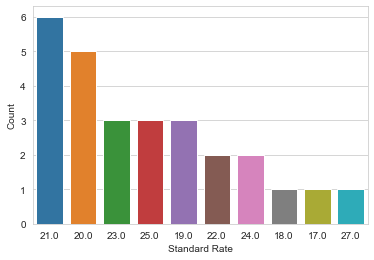

In [17]:
stvat = sns.countplot(x='standard_rate', \
                      data=df_flattened, \
                      order = df_flattened['standard_rate'].value_counts().index)
stvat.set(xlabel='Standard Rate', ylabel='Count')

Query with PySpark

In [18]:
spark_df.groupby('standard_rate').count().orderBy('count', ascending=False).show()

+-------------+-----+
|standard_rate|count|
+-------------+-----+
|         21.0|    6|
|         20.0|    5|
|         19.0|    3|
|         25.0|    3|
|         23.0|    3|
|         22.0|    2|
|         24.0|    2|
|         27.0|    1|
|         17.0|    1|
|         18.0|    1|
+-------------+-----+



Get countries with most common standard tax rates (21.0 and 20.0)

In [19]:
spark.sql("SELECT a.country, a.standard_rate, b.std_count \
           FROM euVATrates a \
                INNER JOIN \
                    (SELECT standard_rate, count(*) AS std_count \
                        FROM euVATrates \
                    GROUP BY standard_rate) b \
                ON a.standard_rate = b.standard_rate AND b.std_count >=5 \
            ORDER BY a.standard_rate").show()

+--------------+-------------+---------+
|       country|standard_rate|std_count|
+--------------+-------------+---------+
|       Estonia|         20.0|        5|
|       Austria|         20.0|        5|
|        France|         20.0|        5|
|      Bulgaria|         20.0|        5|
|      Slovakia|         20.0|        5|
|       Belgium|         21.0|        6|
|         Spain|         21.0|        6|
|Czech Republic|         21.0|        6|
|     Lithuania|         21.0|        6|
|        Latvia|         21.0|        6|
|   Netherlands|         21.0|        6|
+--------------+-------------+---------+



# Countries which are more than 20% above the average of standard VAT rate

Query with PySpark methods

In [20]:
avg = spark_df.select(mean('standard_rate')).collect()[0][0]
print('Average: {}'.format(avg))
print('20% above average: {}'.format(avg * 1.2))
spark_df.select('country', 'standard_rate').where(spark_df['standard_rate'] > avg * 1.2).show()

Average: 21.51851851851852
20% above average: 25.822222222222223
+-------+-------------+
|country|standard_rate|
+-------+-------------+
|Hungary|         27.0|
+-------+-------------+



Query with SQL

In [21]:
spark.sql("SELECT country, standard_rate \
          FROM euVATrates \
          WHERE standard_rate > (SELECT avg(standard_rate) FROM euVATrates) * 1.2").show()

+-------+-------------+
|country|standard_rate|
+-------+-------------+
|Hungary|         27.0|
+-------+-------------+



# Countries where the range between reduced and standard rate is not overlapping

Remove records that don't have the reduced_rate value

In [22]:
spark_df_reduced = spark_df.select('country', 'reduced_rate', 'standard_rate') \
                    .where(spark_df['reduced_rate'] != 0)
spark_df_reduced.count()

26

In [23]:
spark_df_reduced.show(26)

+--------------+------------+-------------+
|       country|reduced_rate|standard_rate|
+--------------+------------+-------------+
|       Austria|        10.0|         20.0|
|       Belgium|        12.0|         21.0|
|      Bulgaria|         9.0|         20.0|
|        Cyprus|         9.0|         19.0|
|Czech Republic|        15.0|         21.0|
|       Germany|         7.0|         19.0|
|       Estonia|         9.0|         20.0|
|         Spain|        10.0|         21.0|
|       Finland|        14.0|         24.0|
|        France|        10.0|         20.0|
|        Greece|        13.0|         24.0|
|       Croatia|        13.0|         25.0|
|       Hungary|        18.0|         27.0|
|       Ireland|        13.5|         23.0|
|         Italy|        10.0|         22.0|
|     Lithuania|         9.0|         21.0|
|    Luxembourg|        14.0|         17.0|
|        Latvia|        12.0|         21.0|
|         Malta|         7.0|         18.0|
|   Netherlands|         9.0|   

In [24]:
spark_df_reduced.createOrReplaceTempView('euVATratesRed') # Create a sample table

Create view with overlapping information between countries

In [34]:
overlaps = spark.sql("SELECT a.country country_A, a.reduced_rate red_A, a.standard_rate std_A, \
                             b.country country_B, b.reduced_rate red_B, b.standard_rate std_B \
                      FROM euVATratesRed a  \
                      INNER JOIN euVATratesRed b \
                        ON a.country <> b.country \
                        AND (a.reduced_rate BETWEEN b.reduced_rate AND b.standard_rate \
                                OR a.standard_rate BETWEEN b.reduced_rate AND b.standard_rate)")
overlaps.show()
overlaps.createOrReplaceTempView('overlaps') # Create a sample table

+---------+-----+-----+--------------+-----+-----+
|country_A|red_A|std_A|     country_B|red_B|std_B|
+---------+-----+-----+--------------+-----+-----+
|  Austria| 10.0| 20.0|       Belgium| 12.0| 21.0|
|  Belgium| 12.0| 21.0|       Austria| 10.0| 20.0|
|  Austria| 10.0| 20.0|      Bulgaria|  9.0| 20.0|
|  Austria| 10.0| 20.0|        Cyprus|  9.0| 19.0|
|  Belgium| 12.0| 21.0|      Bulgaria|  9.0| 20.0|
|  Belgium| 12.0| 21.0|        Cyprus|  9.0| 19.0|
|  Austria| 10.0| 20.0|Czech Republic| 15.0| 21.0|
|  Austria| 10.0| 20.0|       Germany|  7.0| 19.0|
|  Belgium| 12.0| 21.0|Czech Republic| 15.0| 21.0|
|  Belgium| 12.0| 21.0|       Germany|  7.0| 19.0|
|  Austria| 10.0| 20.0|       Estonia|  9.0| 20.0|
|  Belgium| 12.0| 21.0|       Estonia|  9.0| 20.0|
|  Austria| 10.0| 20.0|         Spain| 10.0| 21.0|
|  Austria| 10.0| 20.0|       Finland| 14.0| 24.0|
|  Belgium| 12.0| 21.0|         Spain| 10.0| 21.0|
|  Belgium| 12.0| 21.0|       Finland| 14.0| 24.0|
|  Austria| 10.0| 20.0|        

In [35]:
overlaps.count()

582

Get countries that don't belong to the previous view

In [36]:
spark.sql("SELECT * FROM euVATratesRed \
           WHERE country NOT IN (SELECT country_A FROM Overlaps) \
            AND country NOT IN (SELECT country_B FROM overlaps) \
           ORDER BY country").show()

+-------+------------+-------------+
|country|reduced_rate|standard_rate|
+-------+------------+-------------+
+-------+------------+-------------+

